In [2]:
from __future__ import division
from astropy.io import fits
import os,glob,sys
import glob
import copy
import numpy as np
from astropy.table import Table, Column
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt


l_w = [3610.51,3650.15,4046.56,4358.33,4678.16,4799.92,5085.82,5460.74,5769.59,5790.65,5875.62]
l_l = ['Cd I', 'Hg I', 'Hg I','Hg I', 'Cd I' , 'Cd I', 'Cd I', 'Hg I', 'Hg I', 'Hg I', 'He']

In [6]:
bias_list = glob.glob('Project_3_data/BIAS/*.fits')
flat_list = glob.glob('Project_3_data/FLAT/*.fits')
arc_list = glob.glob('Project_3_data/ARC/*.fits')
UGC_list = glob.glob('Project_3_data/UGC7321/*.fits')

In [22]:
#define a functioon that saves the fits
def write_hdulist_to(hdulist, fileobj, overwrite= True, **kwargs):
    hdulist.writeto(fileobj, overwrite = True, **kwargs)

### Master Bias

In [23]:
#Define a zero array
master_bias = np.zeros(fits.getdata(bias_list[0]).shape)

#Get master bias(mean)
for i in range(len(bias_list)):
    master_bias += fits.getdata(bias_list[i])

master_bias /= len(bias_list)
#cut the over scanned area
m_bias = master_bias[80:2650,100:400]

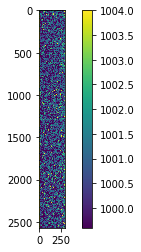

In [24]:
plt.imshow(m_bias,vmin = np.percentile(master_bias,16),vmax = np.percentile(master_bias,84))
plt.colorbar()

### Master Flat

In [25]:
#Define a zero array for flat
m_flat = np.zeros((m_bias.shape[0],m_bias.shape[1],len(flat_list)))

#Get master flat and normalize
for i in range(len(flat_list)):
    hdr_f = fits.getdata(flat_list[i])
    hdr_f = hdr_f[80:2650,100:400]
    m_flat[:,:,i] = (hdr_f - m_bias)
    
    
print('shape of flat series',m_flat.shape)
m_flat = np.mean(m_flat, axis = 2)
m_flat /= np.mean(m_flat)

shape of flat series (2570, 300, 5)


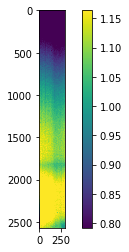

In [26]:
plt.imshow(m_flat,vmin = np.percentile(m_flat,16),vmax = np.percentile(m_flat,84))
plt.colorbar()

### Calibrate for ARC

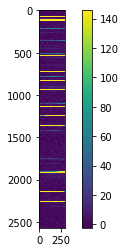

In [37]:
m_arc = np.zeros((m_bias.shape[0],m_bias.shape[1],len(arc_list))) 

for i in range(len(arc_list)):
    hdu_arc = fits.open(arc_list[i],mode='update')
    hdu_arcdata = hdu_arc[0].data
    hdu_archdr = hdu_arc[0].header
    obs_num = hdu_archdr['OBSNUM']
    #define names for the files
    uni_ID = 'arc'+'_'+str(obs_num)
    #chop the images
    hdu_arcdata = hdu_arcdata[80:2650,100:400]
    #do the data reducation
    m_arc[:,:,i] = (hdu_arcdata - m_bias)
    arc = np.divide(m_arc[:,:,i], m_flat, out=np.zeros_like(m_arc[:,:,i]), where=m_flat!=0)
    #save every image
    outhdu = fits.PrimaryHDU(data = arc, header = hdu_archdr)
    write_hdulist_to(outhdu, 'Project_3_data/ARC/Reduced_ARC/{}.fits'.format(uni_ID))
    
n = 0
plt.imshow(m_arc[:,:,n],vmin = np.percentile(m_arc[:,:,n],5),vmax = np.percentile(m_arc[:,:,n],95))
plt.colorbar()

In [39]:
#open the reduced arc and stack
red_arc_list = glob.glob('Project_3_data/ARC/Reduced_ARC/*.fits')

#make an array of images from the list of images
arc_concat = [fits.getdata(image) for image in red_arc_list] 

#stack the images together with mean
stacked_arc = np.mean(arc_concat, axis=0)

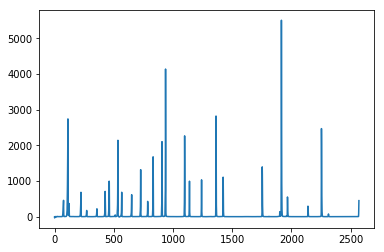

In [45]:
arc2D = stacked_arc
arc1D = np.mean(arc2D,axis=1)

arc1D_list = list(arc1D)
list1 = list(arc1D)
list1.sort()

plt.plot(arc1D)

In [46]:
# set up calibration points

length = len(list1) 
cali1 = arc1D_list.index(list1[length-1])
cali2 = arc1D_list.index(list1[length-3])
cali3 = arc1D_list.index(list1[length-5])
cali4 = arc1D_list.index(list1[length-8])
cali5 = arc1D_list.index(list1[length-10])
cali6 = arc1D_list.index(list1[length-12])

cali7 = arc1D_list.index(list1[length-13])
cali8 = arc1D_list.index(list1[length-18])
cali9 = arc1D_list.index(list1[length-22])


or1 = 7032.413 #
or2 = 6402.246 #
or3 = 6678.276 #
or4 = 7245.167 #
or5 = 6506.528 #
or6 = 6143.062 #

or7 = 6382.991 #
or8 = 6334.428 # 
or9 = 6929.468 # 

x = np.array([cali1, cali2, cali3, cali4, cali5,
              cali6,cali7, cali8, cali9])
y = np.array([or1, or2, or3, or4, or5,or6,
             or7,or8,or9])
print(x)

[1915  937 1363 2253 1098  535  907  832 1753]


calibration parameteres 0.6428146133864798 5800.269909667837


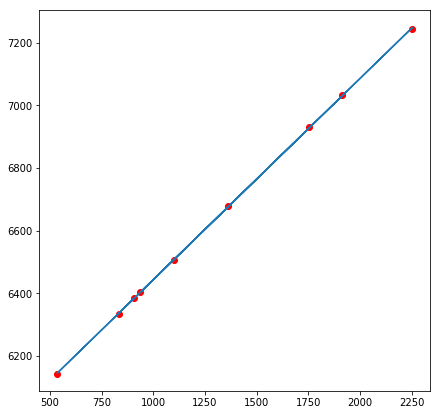

In [48]:
plt.figure(figsize=(7,7))
plt.scatter(x,y,c='r')

a_fit, b_fit = np.poly1d(np.polyfit(x, y, 1)) #weight with uncertainties
print('calibration parameteres',a_fit, b_fit)

y_fit = a_fit *x + b_fit
plt.plot(x,y_fit,label='fit')